In [40]:
import sklearn
import requests
import spacy
import numpy as np
from collections import defaultdict
from sklearn.cluster import KMeans
import random
import matplotlib.cm as cm 

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [37]:
# A Presentation Layer over the Semantic Scholar API

# Load Abstracts from Semantic Scholar
def load_abstracts(query, max_results=100):
    url = 'https://api.semanticscholar.org/graph/v1/paper/search'
    params = {'query': query, 'limit': max_results}

    r = requests.get(url, params=params)
    return r

resps = load_abstracts("machine learning", 100)

titles = [resp['title'] for resp in resps.json()['data']]

titles

['TensorFlow: A system for large-scale machine learning',
 'TensorFlow: Large-Scale Machine Learning on Heterogeneous Distributed Systems',
 'Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms',
 'Machine learning - a probabilistic perspective',
 'Data Mining Practical Machine Learning Tools and Techniques',
 'Scikit-learn: Machine Learning in Python',
 'Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting',
 'Practical Bayesian Optimization of Machine Learning Algorithms',
 'Gaussian Processes for Machine Learning',
 'Neural Machine Translation by Jointly Learning to Align and Translate',
 'A Survey on Bias and Fairness in Machine Learning',
 'An Introduction to Machine Learning',
 'Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead',
 'C4.5: Programs for Machine Learning',
 'Pattern Recognition and Machine Learning',
 'Optimization Methods for Large-Scale Machi

In [45]:
# make the embeddings
nlp = spacy.load("en_core_web_sm")
embeddings = np.vstack([nlp(t).vector for t in titles])

In [50]:
# clustering
cluster = KMeans(4)
categories = cluster.fit_predict(embeddings)

# build index
index = defaultdict(set)
for category, item in zip(categories, titles):
    index[category].add(item)

In [122]:
class Swiper:
    def __init__(self, index):
        self.index = index

        self.current_category = random.choice(list(self.index))
        self.current_paper  = None

        self.visited = set()
        # ones that you've swiped left on
        self.bad_categories = set()

        self.switch_paper()

    def switch_paper(self):
        # add current paper to visited
        if self.current_paper:
                self.visited.add(self.current_paper)
        # select new paper from current category
        candidate_papers = self.index[self.current_category] - self.visited

        if candidate_papers:
            self.current_paper = random.choice(list(candidate_papers))
            self.visited.add(self.current_paper)
            # update current paper
            self.current_paper = random.choice(list(candidate_papers))
        else:
            # switch category
            self.switch_category()
            # switch paper
            self.switch_paper()

    def switch_category(self):
        # select new category, exclusding bad categories
        candidate_categories = {*index} - self.bad_categories

        if candidate_categories:
            self.current_category = random.choice(list(candidate_categories))
        else:
            # no more categories to visit
            raise StopIteration("exhausted all categories")
        
    def swipe_left(self):
        # add current category to bad categories
        self.bad_categories.add(self.current_category)
        self.switch_category()
        self.switch_paper()
    
    def swipe_right(self):
        self.switch_paper()

    def tinder(self):
        while True:
            print("\nSuggestion:", self.current_paper)

            print(self.visited)
            ans = None
            while ans not in {"y", "n", "exit"}:
                ans = input("Is this a good pick? (y/n/exit)")
            if ans == "y":
                self.swipe_right()
            elif ans == "n":
                self.swipe_left()
            else:
                break
        
foo = Swiper(index)
foo.tinder()


Suggestion: Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms
{'Double/Debiased Machine Learning for Treatment and Structural Parameters'}

Suggestion: Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems
{'Double/Debiased Machine Learning for Treatment and Structural Parameters', 'Automated Machine Learning: Methods, Systems, Challenges', 'Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms'}

Suggestion: MoleculeNet: A Benchmark for Molecular Machine Learning
{'Double/Debiased Machine Learning for Treatment and Structural Parameters', 'Automated Machine Learning: Methods, Systems, Challenges', 'Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems', 'Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms', 'Machine Learning with Adversaries: Byzantine Tolerant Gr

In [127]:
foo.visited

{'Automated Machine Learning: Methods, Systems, Challenges',
 'Data Mining Practical Machine Learning Tools and Techniques',
 'Double/Debiased Machine Learning for Treatment and Structural Parameters',
 'Fairness in Machine Learning',
 'Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms',
 'Federated Machine Learning',
 'Genetic Algorithms in Search Optimization and Machine Learning',
 'Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems',
 'Machine Learning with Adversaries: Byzantine Tolerant Gradient Descent',
 'MoleculeNet: A Benchmark for Molecular Machine Learning'}

In [128]:
embedding_ = {t: e for e, t in zip(embeddings, titles)}
# Embedding locations
locs = [embedding_[v] for v in foo.visited]
control = [embedding_[v] for v in titles[:len(foo.visited)]]

In [112]:
tsne_map = [(t,e) for t,e in zip(X, embeddings)]

# find the embedding in tsne map
def find_embedding(embedding):
    for t,e in tsne_map:
        if np.all(e == embedding):
            return t
    return None


coords = [find_embedding(e) for e in locs]

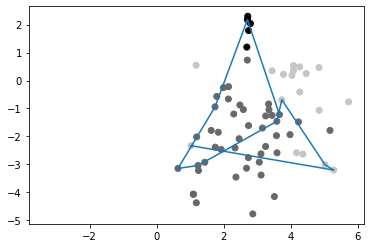

In [130]:
def colors(n_clusters):
    cmap = cm.get_cmap('Greys_r')
    colors = cmap(np.linspace(0, 1, n_clusters))

    return colors

X = TSNE(n_components = 2, perplexity = 40, n_iter = 350).fit_transform(embeddings)


embedding_ = {t: e for e, t in zip(embeddings, titles)}
# Embedding locations
locs = [embedding_[v] for v in foo.visited]

tsne_map = [(t,e) for t,e in zip(X, embeddings)]


# find the embedding in tsne map
def find_embedding(embedding):
    for t,e in tsne_map:
        if np.all(e == embedding):
            return t
    return None


coords = [find_embedding(e) for e in locs]

cmap = colors(categories.max() + 1)
cols = [cmap[c] for c in categories]

plt.scatter(X[:,0], X[:,1], c = cols)

# plot coords
plt.plot(*zip(*coords))